In [1]:
require 'nn'
require 'nngraph'
require 'load_images'
require 'torch'
require 'optim'

In [51]:
-- Set up Logger

nngraph.setDebug(true)
logger = optim.Logger('loss_log.txt')

In [3]:
-- Load data

images = load_images.load('datasets/Set14/image_SRF_4/', 'png', false)
inputChannels = 3

-- Convert greyscale images
for i = 1, #images do
        images[i] = images[i]:expand(inputChannels, images[i]:size(2), images[i]:size(3))
end

n = #images / 2

imagesLR = {}--images:select()
imagesHR = {}--images[2]

for i = 1, n do
	imagesLR[i] = images[2 * i]
	imagesHR[i] = images[2 * i - 1]
end

In [ ]:
-- Make network
--[[
upscaleFactor = 4

net = nn.Sequential()
net:add(nn.SpatialConvolution(inputChannels, 6, 3, 3, 1, 1, 1, 1))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(6, 6, 3, 3, 1, 1, 1, 1))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(6, 32, 5, 5, 1, 1, 2, 2))
net:add(nn.ReLU())
net:add(nn.SpatialConvolution(32, inputChannels * upscaleFactor * upscaleFactor, 3, 3, 1, 1, 1, 1))
net:add(nn.PixelShuffle(upscaleFactor))

--net:add(nn.SpatialFullConvolution(32, 3, 9, 9, upscaleFactor, upscaleFactor, 3, 3, 1, 1))

--graph.dot(net.fg, 'cnn1', 'cnn1')
]]

In [4]:
-- Load network from disk
net = torch.load("upscaleDeConv.model")

In [57]:
-- Train network

criterion = nn.MSECriterion()

x, dl_dx = net:getParameters()

feval = function(x_new)
   
   if x ~= x_new then
      x:copy(x_new)
   end

   -- select a new training sample
   _nidx_ = (_nidx_ or 0) + 1
   if _nidx_ > #imagesHR then _nidx_ = 1 end

   --local sample = data[_nidx_]
   local target = imagesHR[_nidx_]      -- this funny looking syntax allows
   local inputs = imagesLR[_nidx_]    -- slicing of arrays.

   -- reset gradients (gradients are always accumulated, to accommodate 
   -- batch methods)
   dl_dx:zero()

   -- evaluate the loss function and its derivative wrt x, for that sample
   local loss_x = criterion:forward(net:forward(inputs), target)
   net:backward(inputs, criterion:backward(net.output, target))

   -- return loss(x) and dloss/dx
   return loss_x, dl_dx
end

sgd_params = {
   learningRate = 1e-3,
   learningRateDecay = 0, --1e-4,
   weightDecay = 0,
   momentum = 0
}

for i = 1,200 do

   -- this variable is used to estimate the average loss
   current_loss = 0

   -- an epoch is a full loop over our training data
   for i = 1, #imagesHR do
      
      _,fs = optim.sgd(feval,x,sgd_params)


      current_loss = current_loss + fs[1]
   end

   -- report average error on epoch
   current_loss = current_loss / #imagesHR
   
    --if i%10 == 0 then
        print('i'..i..' loss = ' .. current_loss)
    --end
   
   logger:add{['training error'] = current_loss}
   logger:style{['training error'] = '-'}
   if i%100 == 0 then
   logger:plot()  
   end
end

-- [[
torch.save("upscaleDeConv.model", net)
print("Model saved")
--]]
print("finished")

i1 loss = 0.0052090377905469	


i2 loss = 0.0052090303739028	


i3 loss = 0.0052090229586546	


i4 loss = 0.005209015544784	


i5 loss = 0.0052090081325584	


i6 loss = 0.0052090007218695	


i7 loss = 0.0052089933127943	


i8 loss = 0.0052089859054142	


i9 loss = 0.0052089784995278	


i10 loss = 0.0052089710951137	


i11 loss = 0.0052089636921991	


i12 loss = 0.0052089562908936	


i13 loss = 0.0052089488913735	


i14 loss = 0.0052089414932255	


i15 loss = 0.0052089340966323	


i16 loss = 0.005208926701408	


i17 loss = 0.0052089193076188	


i18 loss = 0.0052089119152781	


i19 loss = 0.0052089045243813	


i20 loss = 0.0052088971348636	


i21 loss = 0.0052088897460864	


i22 loss = 0.0052088823596444	

i23 loss = 0.0052088749746091	


i24 loss = 0.0052088675909811	


i25 loss = 0.0052088602087411	


i26 loss = 0.0052088528279264	


i27 loss = 0.0052088454485159	


i28 loss = 0.0052088380705084	


i29 loss = 0.0052088306938924	


i30 loss = 0.0052088233186718	


i31 loss = 0.00520881594484	


i32 loss = 0.005208808572393	


i33 loss = 0.0052088011992023	


i34 loss = 0.0052087938296295	


i35 loss = 0.005208786459442	


i36 loss = 0.0052087790921623	


i37 loss = 0.0052087717261621	


i38 loss = 0.0052087643615963	


i39 loss = 0.0052087569987591	


i40 loss = 0.0052087496367899	


i41 loss = 0.0052087422761842	


i42 loss = 0.0052087349169367	


i43 loss = 0.0052087275587321	


i44 loss = 0.005208720202679	


i45 loss = 0.0052087128479444	


i46 loss = 0.0052087054945307	


i47 loss = 0.0052086981421037	


i48 loss = 0.0052086907911608	


i49 loss = 0.0052086834418578	


i50 loss = 0.0052086760938335	


i51 loss = 0.0052086687471056	


i52 loss = 0.0052086614016775	


i53 loss = 0.005208654057438	


i54 loss = 0.005208646714564	


i55 loss = 0.0052086393729533	


i56 loss = 0.0052086320327691	


i57 loss = 0.0052086246938756	


i58 loss = 0.0052086173562751	


i59 loss = 0.0052086100198084	


i60 loss = 0.0052086026848621	


i61 loss = 0.0052085953511888	


i62 loss = 0.0052085880190366	


i63 loss = 0.005208580687863	


i64 loss = 0.0052085733579798	


i65 loss = 0.0052085660293802	


i66 loss = 0.0052085587023973	


i67 loss = 0.0052085513766247	


i68 loss = 0.0052085440521231	


i69 loss = 0.0052085367288902	


i70 loss = 0.0052085294068514	


i71 loss = 0.0052085220860116	


i72 loss = 0.005208514766298	


i73 loss = 0.0052085074476771	


i74 loss = 0.005208500130568	


i75 loss = 0.0052084928143754	


i76 loss = 0.0052084854993877	


i77 loss = 0.0052084781856772	


i78 loss = 0.0052084708731407	


i79 loss = 0.0052084635618347	


i80 loss = 0.0052084562509895	


i81 loss = 0.0052084489426623	


i82 loss = 0.0052084416353829	


i83 loss = 0.0052084343292788	


i84 loss = 0.0052084270243401	


i85 loss = 0.0052084197205743	


i86 loss = 0.0052084124176653	


i87 loss = 0.005208405116185	


i88 loss = 0.0052083978152336	


i89 loss = 0.0052083905160397	


i90 loss = 0.0052083832181974	


i91 loss = 0.005208375921846	


i92 loss = 0.005208368626931	


i93 loss = 0.0052083613331503	


i94 loss = 0.0052083540405065	


i95 loss = 0.0052083467490321	


i96 loss = 0.0052083394588696	


i97 loss = 0.0052083321698281	


i98 loss = 0.0052083248819132	


i99 loss = 0.0052083175951367	


i100 loss = 0.0052083103094119	


i101 loss = 0.0052083030250614	


i102 loss = 0.0052082957426003	


i103 loss = 0.0052082884605616	


i104 loss = 0.0052082811797818	


i105 loss = 0.0052082738994343	


i106 loss = 0.0052082666211571	


i107 loss = 0.0052082593439602	


i108 loss = 0.0052082520679848	


i109 loss = 0.0052082447931517	


i110 loss = 0.0052082375197315	


i111 loss = 0.0052082302475721	


i112 loss = 0.0052082229763836	


i113 loss = 0.0052082157063127	


i114 loss = 0.0052082084369647	


i115 loss = 0.0052082011672746	


i116 loss = 0.0052081939005613	


i117 loss = 0.0052081866347721	


i118 loss = 0.0052081793701207	


i119 loss = 0.0052081721064876	


i120 loss = 0.0052081648439997	


i121 loss = 0.0052081575829776	


i122 loss = 0.0052081503234846	


i123 loss = 0.0052081430647469	


i124 loss = 0.0052081358072314	


i125 loss = 0.0052081285511482	


i126 loss = 0.0052081212961695	


i127 loss = 0.0052081140429417	


i128 loss = 0.0052081067907473	


i129 loss = 0.0052080995396344	


i130 loss = 0.0052080922895892	


i131 loss = 0.0052080850410693	


i132 loss = 0.0052080777934241	


i133 loss = 0.0052080705470535	


i134 loss = 0.0052080633017326	


i135 loss = 0.0052080560574595	


i136 loss = 0.0052080488141853	


i137 loss = 0.0052080415719907	


i138 loss = 0.0052080343308529	


i139 loss = 0.0052080270905761	


i140 loss = 0.0052080198519299	


i141 loss = 0.0052080126134	


i142 loss = 0.0052080053759403	


i143 loss = 0.0052079981385467	


i144 loss = 0.0052079909017999	


i145 loss = 0.0052079836660518	


i146 loss = 0.0052079764313608	


i147 loss = 0.0052079691976983	


i148 loss = 0.0052079619647451	


i149 loss = 0.005207954732708	


i150 loss = 0.0052079475012447	


i151 loss = 0.005207940270681	


i152 loss = 0.0052079330411677	


i153 loss = 0.0052079258125113	


i154 loss = 0.0052079185851288	


i155 loss = 0.005207911357965	


i156 loss = 0.0052079041335021	


i157 loss = 0.0052078969097773	


i158 loss = 0.0052078896869417	


i159 loss = 0.0052078824650334	


i160 loss = 0.0052078752440616	


i161 loss = 0.0052078680240429	


i162 loss = 0.005207860804977	


i163 loss = 0.0052078535868691	


i164 loss = 0.0052078463697744	


i165 loss = 0.0052078391535919	


i166 loss = 0.005207831938182	


i167 loss = 0.005207824723903	


i168 loss = 0.0052078175104332	


i169 loss = 0.0052078102982011	


i170 loss = 0.0052078030869136	


i171 loss = 0.0052077958765724	


i172 loss = 0.0052077886671691	


i173 loss = 0.0052077814587142	


i174 loss = 0.0052077742512583	


i175 loss = 0.0052077670423297	


i176 loss = 0.0052077598369004	


i177 loss = 0.0052077526324552	


i178 loss = 0.0052077454285897	


i179 loss = 0.0052077382256259	


i180 loss = 0.0052077310235705	


i181 loss = 0.005207723822447	


i182 loss = 0.0052077166222311	


i183 loss = 0.005207709422943	


i184 loss = 0.005207702225295	


i185 loss = 0.0052076950275007	


i186 loss = 0.0052076878308898	


i187 loss = 0.0052076806351896	


i188 loss = 0.0052076734403862	


i189 loss = 0.0052076662464969	


i190 loss = 0.0052076590535443	


i191 loss = 0.0052076518615084	


i192 loss = 0.005207644670479	


i193 loss = 0.0052076374809598	


i194 loss = 0.005207630293231	


i195 loss = 0.0052076231060312	


i196 loss = 0.0052076159201391	


i197 loss = 0.0052076087351387	


i198 loss = 0.0052076015510192	


i199 loss = 0.0052075943677896	


i200 loss = 0.0052075871827859	


Model saved	
finished	


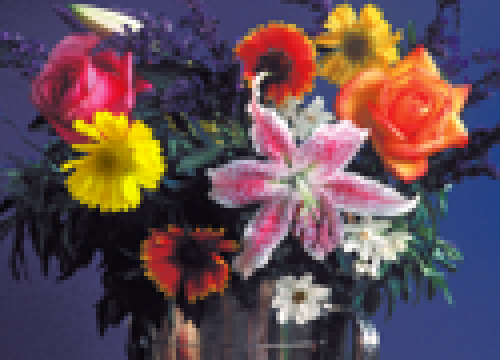

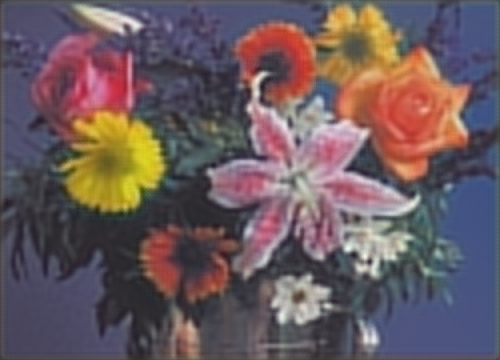

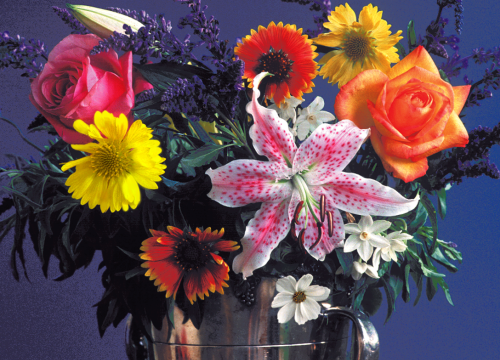

In [61]:
-- Test example

imgselector = 7

local origin = imagesLR[imgselector]
local gt = imagesHR[imgselector]
local test = net:forward(origin)
local scaled = image.scale(origin, gt:size(3), gt:size(2), 'simple') -- upscaled(nearest neighbor) LR
local scaledbl = image.scale(origin, gt:size(3), gt:size(2), 'bilinear') -- upscaled(nearest neighbor) LR
local scaledbc = image.scale(origin, gt:size(3), gt:size(2), 'bicubic') -- upscaled(nearest neighbor) LR
local diff = torch.add(gt, -1, test)
local diff2 = torch.add(scaledbc, -1, test)

image.save("test.png", test)

-- [[
--itorch.image(.....) -- difference between output and LR
itorch.image(scaled) -- upscaled LR
--itorch.image(scaledbl) -- upscaled(bilinear) LR
--itorch.image(scaledbc) -- upscaled(bicubic) LR
itorch.image(test) -- output 
itorch.image(gt) -- HR
--itorch.image(diff) -- difference between output and HR
--]]

--[[
itorch.image({image.crop(scaled, 'bl', gt:size(3)/2, gt:size(2)/2),image.crop(scaledbc, 'bl', gt:size(3)/2, gt:size(2)/2)})
itorch.image({image.crop(gt, 'bl', gt:size(3)/2, gt:size(2)/2),image.crop(test, 'bl', gt:size(3)/2, gt:size(2)/2)})
itorch.image(diff) -- difference between output and HR
itorch.image(diff2) -- difference between output and upscaleBC
--]]

In [ ]:
print(net)